# Feature selection on the Titanic survivors dataset

### In this notebook

0. data curation
1. info theory
2. pairwise mutual information ranks
3. QUBO
4. Model predictions

In [1]:
%matplotlib inline

In [471]:
from pylab import *
import random

In [3]:
import pandas as pd

In [4]:
import re

### 0. data curation

This section borrows heavily from https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [5]:
# Load in the train and test datasets
train = pd.read_csv('~/Data/Titanic/train.csv')
test = pd.read_csv('~/Data/Titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
full_data = [train, test]

In [7]:
SFD = ['Ticket'] #columns scheduled for deletion

#### name

name length

In [8]:
#add name length feature
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)

name title

In [9]:
# extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare_title')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [10]:
dataset.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare_title'], dtype=object)

In [11]:
for dataset in full_data:
    for Title in dataset.Title.unique():
        dataset[Title]=dataset['Title'].apply(lambda x: 1 if x==Title else 0)

In [12]:
SFD.append('Name') #schedule for deletion
SFD.append('Title') #schedule for deletion

#### alone

In [13]:
#add if passenger travels alone
for dataset in full_data:
    dataset['Alone'] = dataset["SibSp"]+dataset["Parch"]
    dataset['Alone'] = dataset['Alone'].apply(lambda x: 1 if x== 0 else 0 )

#### cabin

In [14]:
#add binary cabin feature
for dataset in full_data:
    dataset['Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#### sex

In [15]:
#add binary cabin feature
for dataset in full_data:
    dataset['Sex'] = dataset["Sex"].apply(lambda x: 0 if x == 'male' else 1)

#### port

In [16]:
for dataset in full_data:
    dataset['port_S']=dataset['Embarked'].apply(lambda x: 1 if x=='S' else 0)
    dataset['port_C']=dataset['Embarked'].apply(lambda x: 1 if x=='C' else 0)
    dataset['port_Q']=dataset['Embarked'].apply(lambda x: 1 if x=='Q' else 0)

In [17]:
SFD.append('Embarked') #schedule for deletion

In [18]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Mr,Mrs,Miss,Master,Rare_title,Alone,port_S,port_C,port_Q
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,Mr,1,0,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,Mrs,0,1,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,0,0,1,0,0,1,1,0,0


In [19]:
SFD = list(set(SFD))
print(SFD)
train = train.drop(SFD,axis=1)
test = test.drop(SFD,axis=1)

['Name', 'Ticket', 'Embarked', 'Title']


In [20]:
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Name_length,Mr,Mrs,Miss,Master,Rare_title,Alone,port_S,port_C,port_Q
0,1,0,3,0,22.0,1,0,7.2500,0,23,1,0,0,0,0,0,1,0,0
1,2,1,1,1,38.0,1,0,71.2833,1,51,0,1,0,0,0,0,0,1,0
2,3,1,3,1,26.0,0,0,7.9250,0,22,0,0,1,0,0,1,1,0,0


it looks like there are some NANs in the data. We'll drop the rows where that happens. Ideally we would like to be robust against that, especially for the purpose of predicting the test data, but we'll not bother with this for now.

In [21]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin            0
Name_length      0
Mr               0
Mrs              0
Miss             0
Master           0
Rare_title       0
Alone            0
port_S           0
port_C           0
port_Q           0
dtype: int64

In [22]:
train = train[np.isfinite(train['Age'])]
test = test[np.isfinite(test['Age'])]

### 1. info theory

Build the joint probability distributions to be used later for the info theory measurements. In order to get good stats, all of the variables that have more than the specified max_class possible values (eg. name_length, fare, age) are binned into max_class number of states. 

In [23]:
def prob(data,max_class=3): 
    '''build joint distribution from data. columns are the variables x_1,...,x_n. it returns P(x_1,...,x_n).
    max_class: maximum number of states per variable desired'''
    if len(data.shape) == 1: bins = min(max_class,len(set(data)))
    else:
        bins = [] #how many bins to use per variable 
        for i in range(data.shape[1]):
            bins.append(min(max_class,len(set(data[:,i]))))
                    
    prob, edges = np.histogramdd(data,bins)
                    
    return prob/np.sum(prob)

In [24]:
p = prob(train[['Survived','Sex','Pclass']].values)

In [26]:
sum(p,axis=(1,2))

array([0.59383754, 0.40616246])

$H(X) = -\sum_x P(x)\mathrm{log}P(x)$

In [511]:
H(sum(p,axis=(1,2)))

0.9744414561311622

In [27]:
def H(prob):
    '''shannon entropy H = -sum_i p_i*log(p_i)'''
    prob = prob.flatten()
    H = 0.
    for p_i in prob[prob!=0]: H -= p_i*np.log2(p_i)
    return H

$H(X|Y) = H(X,Y)-H(Y)$

In [28]:
def H_cond_j(prob,j):
    '''entropy of P conditional on variable j'''
    non_j = arange(len(prob.shape))#non_j indices
    non_j = tuple(non_j[non_j!=j])
    return H(prob) - H(sum(prob,axis=non_j))

$I(X;Y) = H(X)-H(X|Y)$

In [29]:
def I(prob,j):
    '''mutual information between all variables and variable j'''
    return H(sum(prob,axis=j)) - H_cond_j(prob,j)

$H(X|Y,Z) = H(X,Y,Z)-H(Y,Z)$

In [30]:
def H_cond_jk(prob,j,k):
    '''entropy of P conditional on variables j k'''
    non_jk = arange(len(prob.shape))#non_j indices
    non_jk = tuple(non_jk[(non_jk!=j)&(non_jk!=k)])
    return H(prob) - H(sum(prob,axis=non_jk))

$I(X;Y|Z) = H(X|Z)-H(X|Y,Z)$

In [31]:
def I_cond_k(prob,j,k):
    '''mutual information between all variables (X) and variable j (Y), conditional on k (Z)'''
    if k < j:
        return H_cond_j(sum(prob,axis=j),k) - H_cond_jk(prob,j,k)
    else:
        return H_cond_j(sum(prob,axis=j),k-1) - H_cond_jk(prob,j,k)

### 2. pairwise mutual information ranks

The most common implementation of feature selection that involves mutual information consists in simply ranking variables features $X_i$ by their mutual information with the target function $Y$, ie $I(X_i;Y)$. This can be implemented with [sklearn.feature_selection.SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) with score_func = mutual_info_classifier.

Let's compare the rankings obtained from the package and our functions defined above (differences may be due to how the variables are binned into discrete states)

#### skit-learn

In [32]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [33]:
model = SelectKBest(mutual_info_classif,'all')
model.fit(train[train.columns[2:]].values,train['Survived'].values)
scikit_scores = model.scores_

In [34]:
scikit_sorted = [[i,e] for i,e in enumerate(scikit_scores)]
scikit_sorted = [i for i,e in sorted(scikit_sorted,key=lambda x: x[1])][::-1]

([<matplotlib.axis.XTick at 0x7f4d1baf7e48>,
 <a list of 17 Text xticklabel objects>)

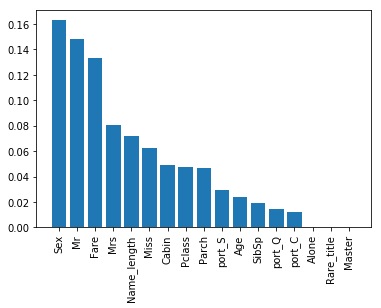

In [35]:
figure()
bar(arange(len(scikit_scores)),scikit_scores[scikit_sorted])
xticks(arange(len(scikit_scores)),train.columns[2:][scikit_sorted],rotation=90)

#### our implementation

In [52]:
our_scores = []
for feature in train.columns[2:]:
    our_scores.append(I(prob(train[['Survived',feature]].values,max_class=3),0))
our_scores = array(our_scores)

In [53]:
our_sorted = [[i,e] for i,e in enumerate(our_scores)]
our_sorted = [i for i,e in sorted(our_sorted,key=lambda x: x[1])][::-1]

([<matplotlib.axis.XTick at 0x7f4d1b37db00>,
 <a list of 17 Text xticklabel objects>)

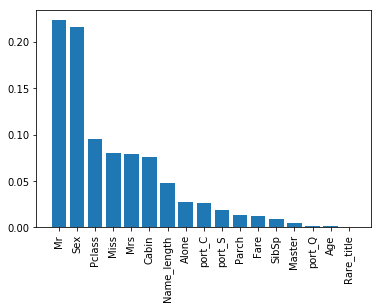

In [54]:
figure()
bar(arange(len(our_scores)),our_scores[our_sorted])
xticks(arange(len(our_scores)),train.columns[2:][our_sorted],rotation=90)

#### method comparison

Although both rank plots look fairly similar, there are some suprising variations. For example, we can extract more information from sex than they do although it's a binary variable. Sciki-learn is better at extracting information from the continuous variable Fare, since we decided to bin Fare into 5 states. Suprisingly, we do much better with Age which is also continuous. Changing the number of max_states changes our results.

Text(0,0.5,'our I(X;Y)')

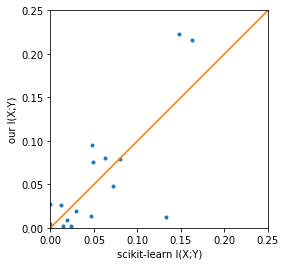

In [55]:
figure()
plot(scikit_scores, our_scores,'. ')
plot([0,.25],[0,.25])
xlim(0,0.25);ylim(0,0.25)
gca().set_aspect('equal')
xlabel('scikit-learn I(X;Y)'); ylabel('our I(X;Y)')

Looking at the scikit-learn documentation I've found this:

'The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances as described in [2] and [3]. Both methods are based on the idea originally proposed in [4].'

[2]	A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.

[3]	B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014.

[4]	L. F. Kozachenko, N. N. Leonenko, “Sample Estimate of the Entropy of a Random Vector:, Probl. Peredachi Inf., 23:2 (1987), 9-16

Later on I'll take look at what that's exactly doing and why would that mess with such a simple binary calculation such as Sex vs Survival.

### 3. QUBO

As it's shown on the slides 'Global Mutual Information Based Feature Selection by Quantum Annealing' by K Tanahashi, S Takayanagi, T Motohashi and S Tanaka. One can use QUBOs to find a subset $X_S$ of features with size $|S|=k$ such that the mutual information $I(X_S;Y)$ between the union of such features and the target variable is maximal, ie

$\hat S = \mathrm{arg max}_{|S|=k} I(X_S;Y)$

This problem has ${N}\choose{k}$ possible solutions, so we will formulate the problem as QUBO in order to solve it with a QPU in constant time.

After assuming conditional-independence for joint probability distributions, $P(X_1,\dots,X_{K},Y|X_{K+1})\approx\prod_{i}^K P(X_i,Y|X_{K+1})$, the problem can be written as follows


<img src=./QUBO.png/>

(^this image has a typo, alpha should be negative)

The green object in the equation above can be further broken down resulting in

$ \hat{\mathbf{x}} = \mathrm{arg min}_{\mathbf{x}\in \{0,1\}} \Big( \mathbf{x}^T \Phi \mathbf{x} \Big)$

with

$\Phi_{i=j} = -I(X_i;Y)+\alpha(1-2k)$

$\Phi_{i\neq j} = -I(X_j;Y|X_i)+\alpha$


In [516]:
def make_Phi(data, k, alpha):
    '''data contains X and Y; Y is the first column; k is the desired number of features; alpha is the penalty for the number-of-features constraint'''
    y_index = 0
    dim = data.shape[1]-1
    Phi = np.zeros((dim,dim))
    
    for i in range(dim):
        for j in range(dim):
                       
                if i == j:
                    Phi[i,j] =  alpha*(1-2*k) -I(prob(data[:,[i+1,y_index]]),1)

                else:
                    Phi[i,j] = alpha -I_cond_k(prob(data[:,[j+1,y_index,i+1]]),1,2)
    return Phi

In [560]:
k = 1
alpha = 200

In [561]:
Phi = make_Phi(train[train.columns[1:]].values, k = k, alpha = alpha)

Solve the problem

In [562]:
def Phi_to_upper_diagonal(Phi):
    Phi_ud = np.zeros(Phi.shape)
    for i in range(len(Phi_ud)):
        Phi_ud[i,i]=Phi[i,i]
        for j in range(i+1,len(Phi_ud)):
            Phi_ud[i,j] = Phi[i,j]+Phi[j,i]
    return Phi_ud

In [563]:
Phi_ud = Phi_to_upper_diagonal(Phi)

In [564]:
import dimod, neal

In [565]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(Phi_ud)

In [566]:
#solver = neal.SimulatedAnnealingSampler()

In [567]:
solver = dimod.ExactSolver()

In [568]:
response = solver.sample(bqm)

In [569]:
state_E = [[list(map(lambda x: s[x], range(len(s)))),e] for s,e in response.data(['sample','energy'])]
state_E = sorted(state_E, key=lambda x: x[1])
state_E = array(state_E)

In [576]:
rank = 0

print('I(X;Y)', -1*state_E[rank][1] - alpha*k**2)
print()
for i, e in enumerate(train.columns[2:]):
    print(e, state_E[rank][0][i])

I(X;Y) 0.21601606075154223

Pclass 0
Sex 1
Age 0
SibSp 0
Parch 0
Fare 0
Cabin 0
Name_length 0
Mr 0
Mrs 0
Miss 0
Master 0
Rare_title 0
Alone 0
port_S 0
port_C 0
port_Q 0


Text(0.5,0,'state rank')

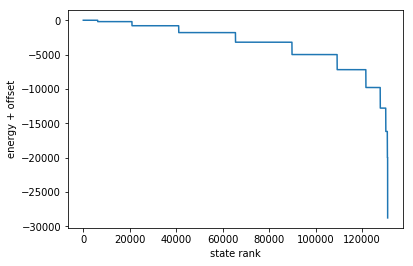

In [551]:
figure()
plot(-1*array(state_E)[:,1] -alpha*k**2)
ylabel('energy + offset'); xlabel('state rank')

We offset the energies by $\alpha k^2$. Since $\alpha(\sum_i x_i - k)^2 = \alpha[ \sum_{i\neq j}x_ix_j +(1-2 k)\sum_ix_i + k^2]$ but the term $\alpha k^2$ was never incorporated into the QBM as it is an energetic offset. When $\sum_i x_i = k$, the 'energy + offset' should be equal to our (over)estimation of mutual information.

negative drops correspond to the penalization of having more than (or less than) 'k' ones in the solution

Text(0,0.5,'occurrence')

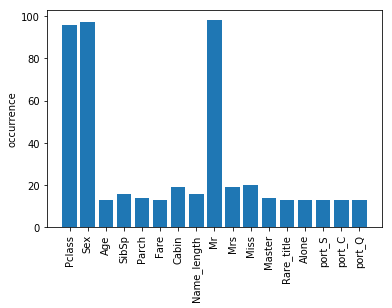

In [552]:
M = []
for i in state_E[:100]:
    M.append(i[0])
M = array(M)

figure()
bar(range(M.shape[1]),sum(M,axis=0))
xticks(arange(M.shape[1]),train.columns[2:],rotation=90)

ylabel('occurrence')

### 4. Model predictions

Now we will predict the survival of Titanic passengers through some simple canned models, on a subset of features k

(1) Selected with our MI-KBest (more easy to compare and dissect than the skitlearn implementation)

(2) Selected with the MIQUBO

#### Prepare the subsets

In [577]:
KB_SS = [] #KBest Subset
for i in range(len(our_sorted)):
    KB_SS.append(our_sorted[:i+1])

In [578]:
QUBO_SS = [] #MI-QUBO Subset
data = train[train.columns[1:]].values
for k in range(1,len(data[0])): #data includes Y as the first column
    #Build BQM
    Phi = make_Phi(data, k = k, alpha = 200)
    Phi_ud = Phi_to_upper_diagonal(Phi)
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(Phi_ud)
    response = solver.sample(bqm)
    #find the selected indices
    E = [[e] for e in response.data(['energy'])]
    min_E_index = E.index(min(E))
    sample = [s for s in response.data(['sample'])][min_E_index][0]
    selection = []
    for i in range(len(data[0])-1):
        if sample[i]==1: selection.append(i)
    QUBO_SS.append(selection)

Text(0.5,1,'QUBO')

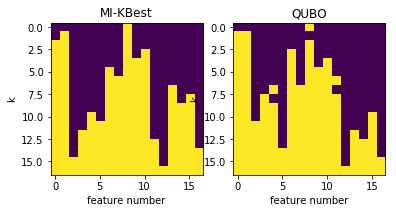

In [583]:
#plot selected features as a function of k
figure()
subplot(1,2,1)
KB_M = np.zeros((len(data[0])-1,len(data[0])-1))
for i in range(len(KB_SS)):
    for j in KB_SS[i]: KB_M[i,j]=1
imshow(KB_M,interpolation='none')
xlabel('feature number'); ylabel('k'); title('MI-KBest')

subplot(1,2,2)
QUBO_M = np.zeros((len(data[0])-1,len(data[0])-1))
for i in range(len(QUBO_SS)):
    for j in QUBO_SS[i]: QUBO_M[i,j]=1
imshow(QUBO_M,interpolation='none')
xlabel('feature number'); ylabel('k'); title('QUBO')

This looks fine except that for the top row, the selected feature should be the same

#### Predict

In [584]:
X, Y = data[:,1:], data[:,0]
indices = arange(len(X))
random.shuffle(indices)
X_train, Y_train = X[indices[:600]], Y[indices[:600]]
X_test, Y_test = X[indices[600:]], Y[indices[600:]]

In [585]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as acc
model = LogisticRegression()

KB_acc, QUBO_acc = [], []
for k in range(len(X[0])):
    model.fit(X_train[:,KB_SS[k]], Y_train)
    Y_pred = model.predict(X_test[:,KB_SS[k]])
    KB_acc.append(acc(Y_pred,Y_test))
    
    model.fit(X_train[:,QUBO_SS[k]], Y_train)
    Y_pred = model.predict(X_test[:,QUBO_SS[k]])
    QUBO_acc.append(acc(Y_pred,Y_test))

(Text(0,0.5,'prediction accuracy'), Text(0.5,1,'logistic regression'))

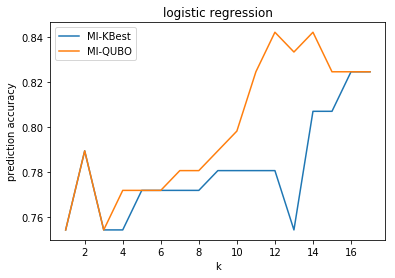

In [588]:
figure()
plot(arange(1,len(X[0])+1),KB_acc,label='MI-KBest')
plot(arange(1,len(X[0])+1),QUBO_acc,label='MI-QUBO')
legend()
xlabel('k'); ylabel('prediction accuracy'), title('logistic regression')